# Titanic: Model Comparison (LR vs RF vs HGB)
**Goal:** compare 3 classical ML models using the same preprocessing, with cross-validation + a final hold-out test.  
**Models:** LogisticRegression, RandomForestClassifier, HistGradientBoostingClassifier  
**Metrics:** Accuracy, F1, ROC AUC  

In [1]:
# 0) Imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

SEED = 42
np.random.seed(SEED)


## 1) Load & inspect data
- we’ll use seaborn’s Titanic dataset.
- a little cleanup (drop a few rows) + define features/target.


In [2]:
titanic = sns.load_dataset("titanic")

# quick peek
display(titanic.head())
print(titanic.isna().mean().sort_values(ascending=False).head(8))

# keep a minimal, commonly-used subset
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
target = "survived"

# drop rows missing critical fields (we'll still impute numeric/categorical later to show best practice)
df = titanic.dropna(subset=["embarked"])  # embarked is small cardinality; drop rare missing rows
X = df[features].copy()
y = df[target].copy()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


deck           0.772166
age            0.198653
embarked       0.002245
embark_town    0.002245
survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
dtype: float64


## 2) Train/validation/test strategy
- we’ll do **5-fold Stratified CV** on the **training portion** only (to compare models fairly).
- then evaluate the chosen/best model on the untouched **hold-out test set**.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## 3) Preprocessing
We need two variants:
- **pre_lr** (for Logistic Regression): impute → **scale** nums, one-hot cats  
- **pre_tree** (for tree models): impute nums (no scaling) + one-hot cats

In [4]:
num_cols = ["age", "sibsp", "parch", "fare", "pclass"]
cat_cols = ["sex", "embarked"]

num_for_lr   = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])

num_for_tree = Pipeline([("imputer", SimpleImputer(strategy="median"))])

cat_common   = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("ohe", OneHotEncoder(handle_unknown="ignore"))])

pre_lr   = ColumnTransformer([("num", num_for_lr,   num_cols),
                              ("cat", cat_common,   cat_cols)])

pre_tree = ColumnTransformer([("num", num_for_tree, num_cols),
                              ("cat", cat_common,   cat_cols)])


## 4) Build model pipelines
Each pipeline = preprocessing + model.

In [5]:
pipelines = {
    "LogReg": Pipeline([
        ("pre", pre_lr),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "RandomForest": Pipeline([
        ("pre", pre_tree),
        ("model", RandomForestClassifier(random_state=SEED))
    ]),
    "HistGradBoost": Pipeline([
        ("pre", pre_tree),
        ("model", HistGradientBoostingClassifier(random_state=SEED))
    ]),
}

scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc",
}


## 5) Cross-validation comparison (on training set only)
We’ll compute mean ± std for each metric. This is your **model ranking** step.

In [6]:
rows = []
cv_results_raw = {}

for name, pipe in pipelines.items():
    res = cross_validate(
        pipe, X_train, y_train,
        cv=cv, scoring=scoring, n_jobs=-1, return_estimator=False
    )
    cv_results_raw[name] = res
    row = {
        "model": name,
        "cv_accuracy_mean": np.mean(res["test_accuracy"]),
        "cv_accuracy_std":  np.std(res["test_accuracy"]),
        "cv_f1_mean":       np.mean(res["test_f1"]),
        "cv_f1_std":        np.std(res["test_f1"]),
        "cv_roc_auc_mean":  np.mean(res["test_roc_auc"]),
        "cv_roc_auc_std":   np.std(res["test_roc_auc"]),
    }
    rows.append(row)

cv_table = pd.DataFrame(rows).sort_values(["cv_f1_mean","cv_accuracy_mean"], ascending=False).reset_index(drop=True)
cv_table

,model,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std
0,HistGradBoost,0.822811,0.029834,0.758279,0.036466,0.867998,0.010222
1,RandomForest,0.815759,0.013556,0.754857,0.018989,0.862016,0.014972
2,LogReg,0.784812,0.033488,0.709971,0.048417,0.844043,0.037451


## 6) Pick the winner (by F1 first, then accuracy)
Then refit that pipeline on the **full training set** and evaluate on the hold-out test set.

Selected best by CV: HistGradBoost

Hold-out classification report:

              precision    recall  f1-score   support

not_survived       0.85      0.87      0.86       110
    survived       0.78      0.75      0.77        68

    accuracy                           0.83       178
   macro avg       0.82      0.81      0.81       178
weighted avg       0.82      0.83      0.83       178



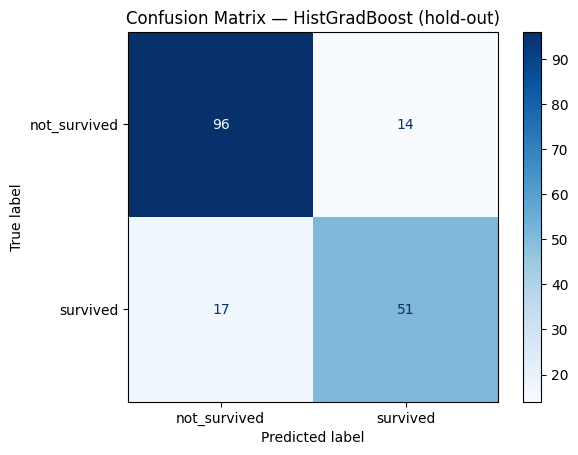

In [7]:
best_name = cv_table.loc[0, "model"]
best_pipe = pipelines[best_name]

print(f"Selected best by CV: {best_name}")

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

print("\nHold-out classification report:\n")
print(classification_report(y_test, y_pred, target_names=["not_survived","survived"]))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["not_survived","survived"]).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix — {best_name} (hold-out)")
plt.show()

## 7) ROC AUC on the hold-out set
We also inspect ROC AUC and curve for the chosen model.

Hold-out ROC AUC: 0.825


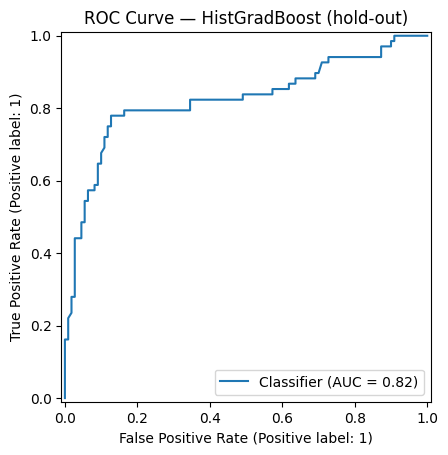

In [8]:
# probability support may differ; all three chosen models provide predict_proba
if hasattr(best_pipe, "predict_proba"):
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"Hold-out ROC AUC: {auc:.3f}")
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve — {best_name} (hold-out)")
    plt.show()
else:
    print("Selected model has no predict_proba; skipping ROC curve.")